# <center> Task 2 : Multi-class Classification on Leaf dataset

**Realized by :** Siwar MHADHBI - Roua MAKHLOUF - Eya GHAMGUI - Hamza MEDDEB

## Overview

In this task, we'll try to explore the **Leaf dataset**, visualize and study the given features on which we'll try to apply dimension reduction techniques if needed. In a second part, we'll try to build machine learning models to classify leaf samples into different classes. Finally, we'll try to draw conclusions based on analysis and interpretations of the results.

## Import necessary libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.io import imread
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_validate

import tensorflow as tf
from skimage.transform import resize
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import balanced_accuracy_score
from tensorflow.keras.layers import Dense, BatchNormalization, Input, Flatten, Dropout, MaxPooling2D, Conv2D

import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = [15, 8]
sns.set(style='darkgrid')

## Data Overview

* For this task, we are provided with different leaf images correponding to different classes. They are represented by Figure1 below. Besides, they are accompagned by their segmentations representing the localization of the leaf in the corresponding image.
 
* We are provided also with a _csv_ file representing the different features of the leaf classes, which are given by Figure3.

<img src="https://docs.google.com/uc?export=download&id=1zszigWMKogLsOBwsHncYOokyK00y_YOM" width="700" height="700">

##### Figure 1: Overview of Leaf Database

### Data Retrieval & Exploration

In [5]:
# Columns names
col=['Class (Species)', 'Specimen Number','Eccentricity','Aspect Ratio',
     'Elongation','Solidity','Stochastic Convexity','Isoperimetric Factor',
     'Maximal Indentation Depth','Lobedness','Average Intensity',
     'Average Contrast','Smoothness','Third moment','Uniformity','Entropy']

# Import data
leaf_data = pd.read_csv('leaf.csv',header=None,names=col)
leaf_data

,Class (Species),Specimen Number,Eccentricity,Aspect Ratio,Elongation,Solidity,Stochastic Convexity,Isoperimetric Factor,Maximal Indentation Depth,Lobedness,Average Intensity,Average Contrast,Smoothness,Third moment,Uniformity,Entropy
0,1,1,0.72694,1.4742,0.32396,0.98535,1.00000,0.835920,0.004657,0.003947,0.047790,0.127950,0.016108,0.005232,0.000275,1.17560
1,1,2,0.74173,1.5257,0.36116,0.98152,0.99825,0.798670,0.005242,0.005002,0.024160,0.090476,0.008119,0.002708,0.000075,0.69659
2,1,3,0.76722,1.5725,0.38998,0.97755,1.00000,0.808120,0.007457,0.010121,0.011897,0.057445,0.003289,0.000921,0.000038,0.44348
3,1,4,0.73797,1.4597,0.35376,0.97566,1.00000,0.816970,0.006877,0.008607,0.015950,0.065491,0.004271,0.001154,0.000066,0.58785
4,1,5,0.82301,1.7707,0.44462,0.97698,1.00000,0.754930,0.007428,0.010042,0.007938,0.045339,0.002051,0.000560,0.000024,0.34214
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,36,6,0.37522,1.1417,0.81725,0.68511,0.58772,0.125230,0.091860,1.535800,0.114880,0.208610,0.041703,0.013344,0.000820,2.02810
336,36,7,0.28064,1.0849,0.75319,0.72152,0.71404,0.136860,0.078996,1.135800,0.141220,0.218300,0.045488,0.012002,0.001515,2.40590
337,36,8,0.35344,1.0329,0.78147,0.70737,0.61579,0.135030,0.089763,1.466400,0.097663,0.207030,0.041101,0.016123,0.000453,1.69350
338,36,9,0.59988,1.1427,0.71532,0.66101,0.47544,0.157470,0.113370,2.339400,0.050389,0.135850,0.018121,0.006190,0.000265,1.15260


**Comment:**


* We can see that our data contains $340$ samples of leaves with $14$ features.
* The first column represents the class of each sample.
* The second column represents the number of leaf specimens available by species.
* The features are devided into **shape features** (next 8 features) and **texture features** (last 6 features).

In [6]:
features = ['Eccentricity', 'Aspect Ratio',
            'Elongation', 'Solidity', 'Stochastic Convexity', 'Isoperimetric Factor',
            'Maximal Indentation Depth', 'Lobedness', 'Average Intensity',
            'Average Contrast', 'Smoothness', 'Third moment', 'Uniformity', 'Entropy']

We visualize first the distribution of the provided classes.

In [ ]:
class_names = ['Quercus suber',  'Salix atrocinera', 'Populus nigra', 'Alnus sp.',
               'Quercus robur', 'Crataegus monogyna', 'Ilex aquifolium', 'Nerium oleander',
               'Betula pubescens', 'Tilia tomentosa', 'Acer palmatumru', 'Celtis sp.',
               'Corylus avellana', 'Castanea sativa', 'Populus alba', 'Primula vulgaris',
               'Erodium sp.', 'Bougainvillea sp.', 'Arisarum vulgare', 'Euonymus japonicus',  'Ilex perado ssp. azorica',
               'Magnolia soulangeana',  'Buxus sempervirens', 'Urtica dioica',  'Podocarpus sp.', 'Acca sellowiana',
               'Hydrangea sp.', 'Pseudosasa japonica', 'Magnolia grandiflora',  'Geranium sp.']

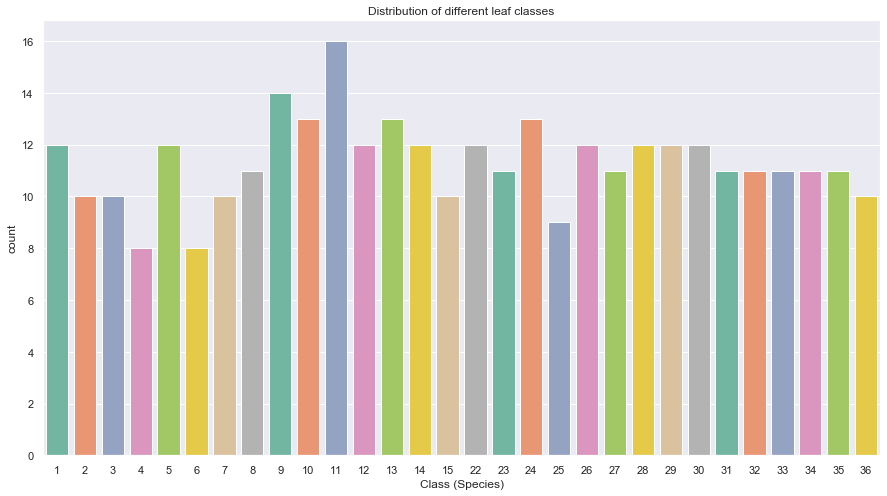

In [ ]:
sns.countplot(x='Class (Species)', data=leaf_data, palette='Set2')
plt.title('Distribution of different leaf classes')

**Comment:**

* Through this countplot, we can see that the data is almost balanced : the highest leaf class is **Acer palmatum** with $16$ samples and the lowest leaf classes are **Alnus sp.** and **Nerium oleander** with $8$ samples.

### Check missing values

In [ ]:
leaf_data.isna().sum().to_frame('Nbr of missing values').T

,Class (Species),Specimen Number,Eccentricity,Aspect Ratio,Elongation,Solidity,Stochastic Convexity,Isoperimetric Factor,Maximal Indentation Depth,Lobedness,Average Intensity,Average Contrast,Smoothness,Third moment,Uniformity,Entropy
Nbr of missing values,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


* We can clearly see that our data does not contain any missing values, which won't raise problems during data processing.

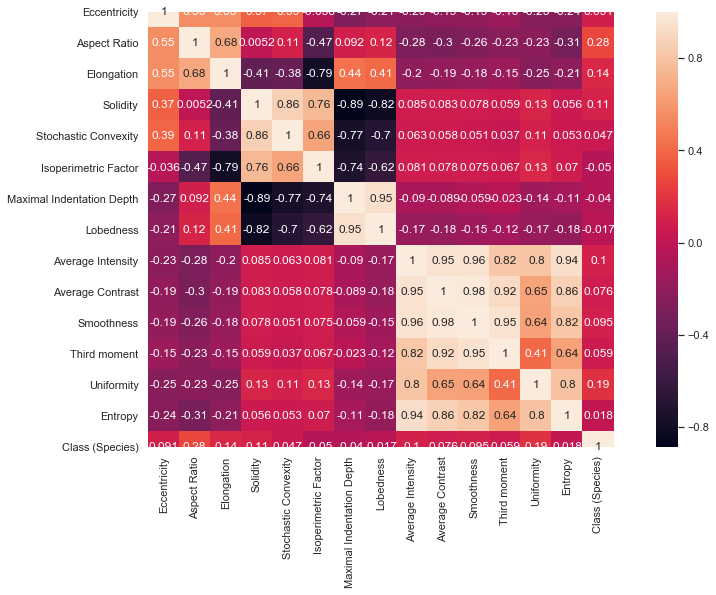

In [ ]:
corrmat = leaf_data[features+['Class (Species)']].corr()
sns.heatmap(corrmat, vmax=1, square=True, annot=True)

**Interpretation:**

* This matrix gives us a summary and exact correlation values between the different numerical features.

* We can see that we have strong correlation in the buttom right block of the matrix corresponding to strong relationship between the 6 texture features : **'Average Intensity', 'Average Contrast', 'Smoothness', 'Third moment', 'Uniformity', and 'Entropy'**.

* We have also 5 of the shape features (**'Solidity', 'Stochastic Convexity', 'Isoperimetric Factor', 'Maximal Indentation Depth', and 'Lobedness'**) that are strongly correlated with positive (light color) and negative (dark color) correlations.

* However, for the rest of the features, they are slightly correlated with correlation between $-0.049$ and $0.2$.

## Feature exploration

### Shape features

* **Aspect Ratio**

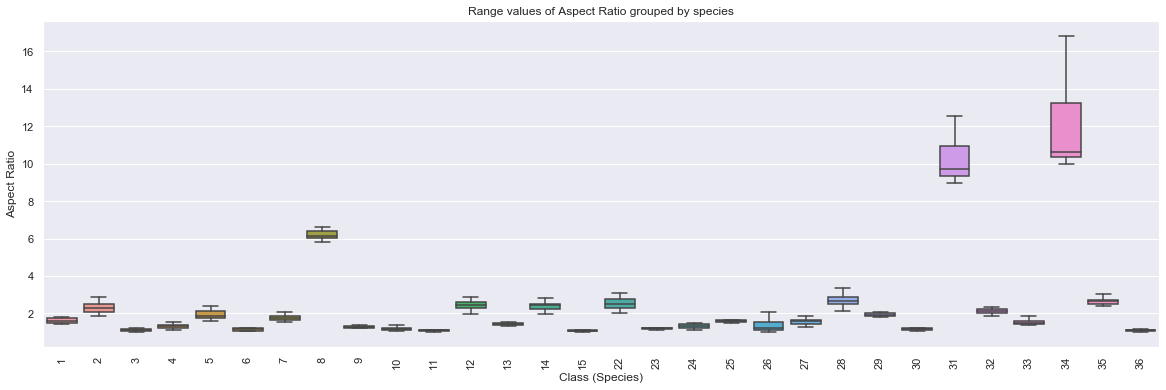

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='Class (Species)', y='Aspect Ratio',
            data=leaf_data, showfliers=False)
plt.title('Range values of Aspect Ratio grouped by species')
plt.xticks(rotation=90)

We can distinguish three classes having high range of values of **Aspect Ratio** feature compared to other classes. <br>
We visualize samples of these classes :

(960, 720, 3)

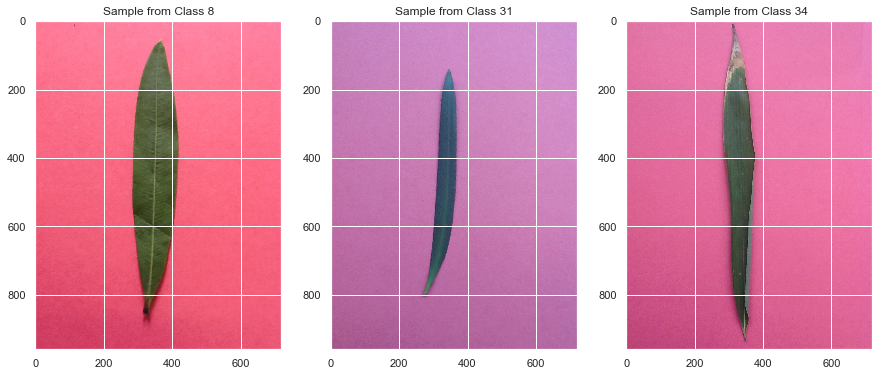

In [ ]:
plt.subplot(1, 3, 1)
plt.title('Sample from Class 8')
plt.imshow(imread('RGB\\8. Nerium oleander\\iPAD2_C08_EX01.jpg'))
plt.subplot(1, 3, 2)
plt.title('Sample from Class 31')
plt.imshow(imread('RGB\\31. Podocarpus sp\\iPAD2_C31_EX01.jpg'))
plt.subplot(1, 3, 3)
plt.title('Sample from Class 34')
plt.imshow(imread('RGB\\34. Pseudosasa japonica\\iPAD2_C34_EX01.jpg'))

**Comment:**

* As we see, the different leaves have a specific shape. They are simple, flattened, and linearly elliptic. Thus, the **Aspect Ratio** measures how much elongated the leaf shape is.

* **Stochastic Convexity**

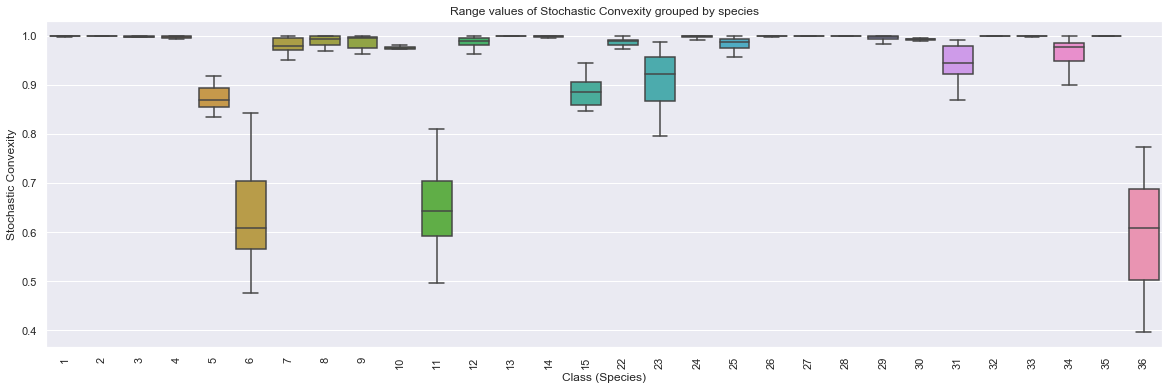

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='Class (Species)', y='Stochastic Convexity',
            data=leaf_data, showfliers=False)
plt.title('Range values of Stochastic Convexity grouped by species')
plt.xticks(rotation=90)

We can distinguish three classes having low range of values of **Stochastic Convexity** feature compared to other classes. <br>
We visualize samples of these classes :

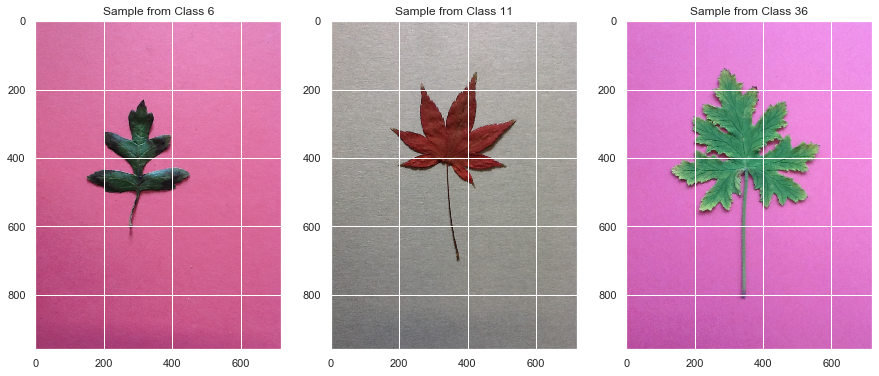

In [ ]:
plt.subplot(1, 3, 1)
plt.title('Sample from Class 6')
plt.imshow(imread('RGB\\6. Crataegus monogyna\\iPAD2_C06_EX01.jpg'))
plt.subplot(1, 3, 2)
plt.title('Sample from Class 11')
plt.imshow(imread('RGB\\11. Acer palmaturu\\iPAD2_C11_EX01.jpg'))
plt.subplot(1, 3, 3)
plt.title('Sample from Class 36')
plt.imshow(imread('RGB\\36. Geranium sp\\iPAD2_C36_EX01.jpg'))

We visualize samples of classes $5$, $15$, and $23$ :

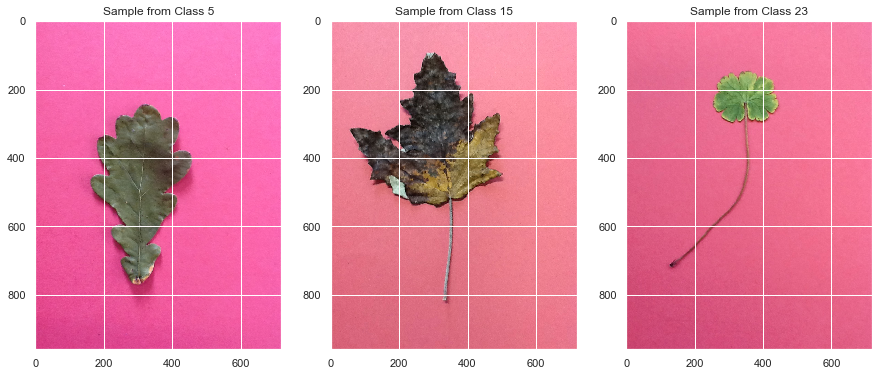

In [ ]:
plt.subplot(1, 3, 1)
plt.title('Sample from Class 5')
plt.imshow(imread('RGB\\5. Quercus robur\\iPAD2_C05_EX01.jpg'))
plt.subplot(1, 3, 2)
plt.title('Sample from Class 15')
plt.imshow(imread('RGB\\15. Populus alba\\iPAD2_C15_EX01.jpg'))
plt.subplot(1, 3, 3)
plt.title('Sample from Class 23')
plt.imshow(imread('RGB\\23. Erodium sp\\iPAD2_C23_EX01.jpg'))

**Comment:**

* From the figure above, we can notice that classes $6$, $11$ and $36$ have very low stochastic convexity values which does make sense since they have similar non convex shapes. In the other hand, leaves in classes $5$, $15$ and $23$ could be classified together having close values and for the rest, we can see that they have strongly high stochastic convexity which is due to their convex shape.

### Texture features

* **Smoothness**

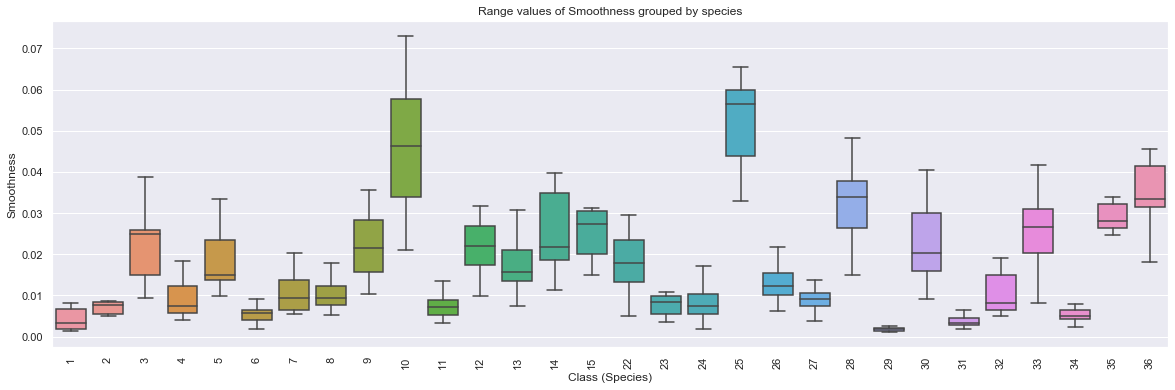

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='Class (Species)', y='Smoothness',
            data=leaf_data, showfliers=False)
plt.title('Range values of Smoothness grouped by species')
plt.xticks(rotation=90)

We can distinguish two classes having highest range of values of **Smoothness** feature compared to other classes. <br>
We visualize samples of these two classes :

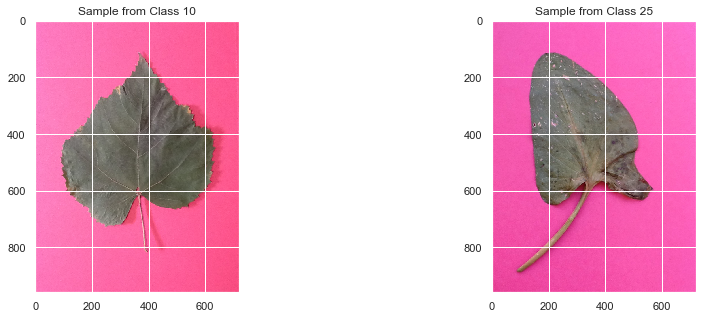

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title('Sample from Class 10')
plt.imshow(imread('RGB\\10. Tilia tomentosa\\iPAD2_C10_EX01.jpg'))
plt.subplot(1, 2, 2)
plt.title('Sample from Class 25')
plt.imshow(imread('RGB\\25. Arisarum vulgare\\iPAD2_C25_EX01.jpg'))

**Comment:**

* From the above boxplot, we can see that both classes $10$ and $25$ have very close smoothness characteristics. Besides, their smoothness values are high regarding other classes. This can be easily seen from the previous image.

* **Uniformity**

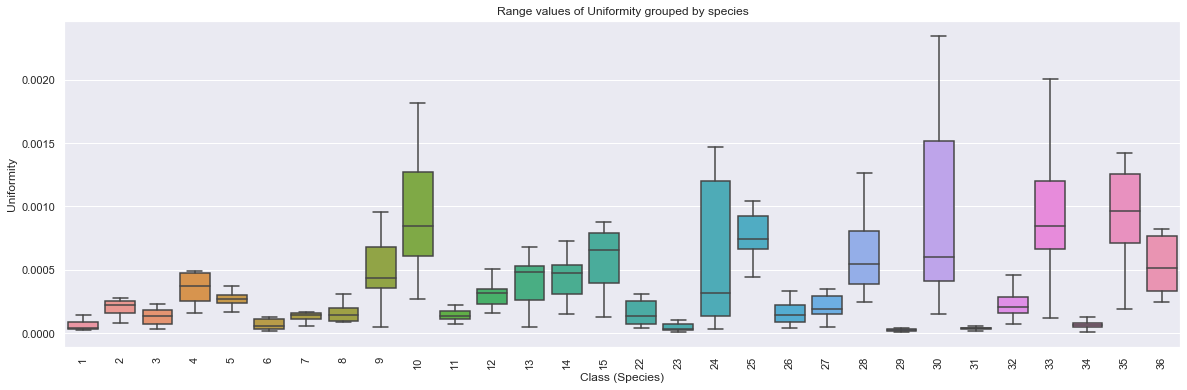

In [ ]:
plt.figure(figsize=(20, 6))
sns.boxplot(x='Class (Species)', y='Uniformity',
            data=leaf_data, showfliers=False)
plt.title('Range values of Uniformity grouped by species')
plt.xticks(rotation=90)

We can distinguish five classes having highest range of values of **Uniformity** feature compared to other classes. <br>
We visualize samples of these two classes :

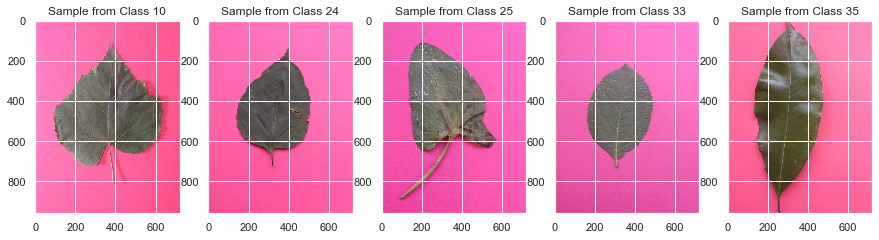

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 5, 1)
plt.title('Sample from Class 10')
plt.imshow(imread('RGB\\10. Tilia tomentosa\\iPAD2_C10_EX01.jpg'))
plt.subplot(1, 5, 2)
plt.title('Sample from Class 24')
plt.imshow(imread('RGB\\24. Bougainvillea sp\\iPAD2_C24_EX01.jpg'))
plt.subplot(1, 5, 3)
plt.title('Sample from Class 25')
plt.imshow(imread('RGB\\25. Arisarum vulgare\\iPAD2_C25_EX01.jpg'))
plt.subplot(1, 5, 4)
plt.title('Sample from Class 33')
plt.imshow(imread('RGB\\33. Hydrangea sp\\iPAD2_C33_EX01.jpg'))
plt.subplot(1, 5, 5)
plt.title('Sample from Class 35')
plt.imshow(imread('RGB\\35. Magnolia grandiflora\\iPAD2_C35_EX01.jpg'))

**Comment:**

* We can clearly remark that those $5$ classes have higher uniformity as intensity levels of images seem very close. 

## Dimension Reduction using PCA

As we saw in the previous section, according to the matrix correlation, there are many strongly correlated features. Thus, we should apply **PCA** in order to remove these correlations that may impact later our models.

* Remove correlation between : **'Solidity', 'Stochastic Convexity', 'Isoperimetric Factor', 'Maximal Indentation Depth', and 'Lobedness'**

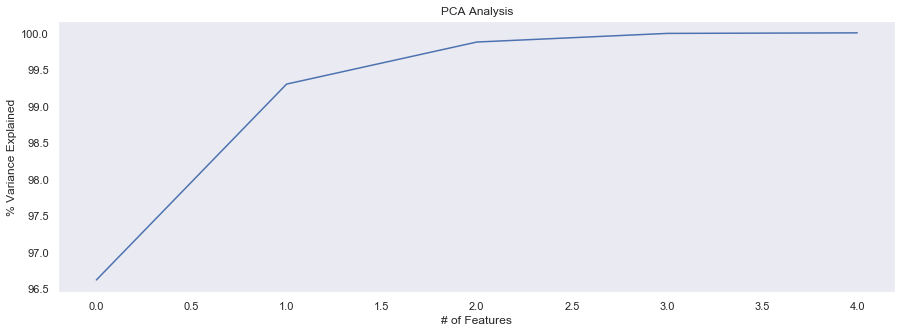

In [ ]:
correlated_shape_features = ['Solidity', 'Stochastic Convexity',
                             'Isoperimetric Factor', 'Maximal Indentation Depth', 'Lobedness']

leaf_data_ = leaf_data[correlated_shape_features]

# Determine the number of components
pca = RandomizedPCA()
pca.fit(leaf_data_)
percentage = pca.explained_variance_ratio_
var = np.cumsum(percentage*100)

# Plot the cumulative variance
plt.figure(figsize=(15, 5))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.plot(np.arange(len(var)), var)
plt.grid()

* As we can clearly see from the curve, $3$ as number of features gives us 100% of the variance explained. Thus, we took n_components = $3$ for the PCA algorithm.

In [ ]:
n_components = 3
pca = RandomizedPCA(n_components=n_components)
leaf_data_pca = pca.fit_transform(leaf_data_)

data2 = leaf_data.drop(columns=correlated_shape_features)
col1 = ['PC1', 'PC2', 'PC3']
leaf_data_pca = (data2.merge(pd.DataFrame(
    leaf_data_pca, index=data2.index, columns=col1), on=data2.index)).set_index(['key_0'])
leaf_data_pca

,Class (Species),Specimen Number,Eccentricity,Aspect Ratio,Elongation,Average Intensity,Average Contrast,Smoothness,Third moment,Uniformity,Entropy,PC1,PC2,PC3
key_0,,,,,,,,,,,,,,
0,1,1,0.72694,1.4742,0.32396,0.047790,0.127950,0.016108,0.005232,0.000275,1.17560,-0.564537,0.229935,-0.048390
1,1,2,0.74173,1.5257,0.36116,0.024160,0.090476,0.008119,0.002708,0.000075,0.69659,-0.558051,0.194127,-0.039372
2,1,3,0.76722,1.5725,0.38998,0.011897,0.057445,0.003289,0.000921,0.000038,0.44348,-0.553970,0.203205,-0.042575
3,1,4,0.73797,1.4597,0.35376,0.015950,0.065491,0.004271,0.001154,0.000066,0.58785,-0.556483,0.210795,-0.046412
4,1,5,0.82301,1.7707,0.44462,0.007938,0.045339,0.002051,0.000560,0.000024,0.34214,-0.546936,0.153521,-0.025470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,36,6,0.37522,1.1417,0.81725,0.114880,0.208610,0.041703,0.013344,0.000820,2.02810,1.098358,-0.343408,-0.197714
336,36,7,0.28064,1.0849,0.75319,0.141220,0.218300,0.045488,0.012002,0.001515,2.40590,0.689936,-0.361243,-0.106101
337,36,8,0.35344,1.0329,0.78147,0.097663,0.207030,0.041101,0.016123,0.000453,1.69350,1.024545,-0.334260,-0.171985


* Remove correlation between : **'Average Intensity', 'Average Contrast','Smoothness','Third moment','Uniformity', and'Entropy'**

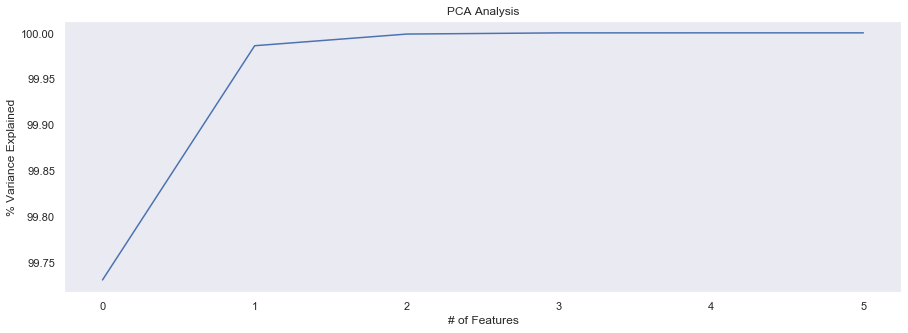

In [ ]:
correlated_texture_features = ['Average Intensity', 'Average Contrast',
                               'Smoothness', 'Third moment', 'Uniformity', 'Entropy']

leaf_data_ = leaf_data[correlated_texture_features]

# Determine the number of components
pca = RandomizedPCA()
pca.fit(leaf_data_)
pca.explained_variance_ratio_
var = np.cumsum(pca.explained_variance_ratio_*100)

# Plot the cumulative variance
plt.figure(figsize=(15, 5))
plt.ylabel('% Variance Explained')
plt.xlabel('# of Features')
plt.title('PCA Analysis')
plt.plot(np.arange(len(var)), var)
plt.grid()

* As we can clearly see from the curve, $3$ as number of features gives us 100% of the variance explained. Thus, we took n_components = $3$ for the PCA algorithm.

In [ ]:
n_components = 3
pca = RandomizedPCA(n_components=n_components)
leaf_data_pca_ = pca.fit_transform(leaf_data_)

leaf_data_pca = leaf_data_pca.drop(columns=correlated_texture_features)
col1 = ['PC4', 'PC5', 'PC6']
leaf_data_pca = (leaf_data_pca.merge(pd.DataFrame(
    leaf_data_pca_, index=leaf_data_pca.index, columns=col1), on=leaf_data_pca.index)).set_index(['key_0'])
leaf_data_pca

,Class (Species),Specimen Number,Eccentricity,Aspect Ratio,Elongation,PC1,PC2,PC3,PC4,PC5,PC6
key_0,,,,,,,,,,,
0,1,1,0.72694,1.4742,0.32396,-0.564537,0.229935,-0.048390,0.012930,-0.000040,-0.005189
1,1,2,0.74173,1.5257,0.36116,-0.558051,0.194127,-0.039372,-0.468178,0.001073,-0.001075
2,1,3,0.76722,1.5725,0.38998,-0.553970,0.203205,-0.042575,-0.723406,-0.010083,0.006906
3,1,4,0.73797,1.4597,0.35376,-0.556483,0.210795,-0.046412,-0.578857,-0.014846,0.004095
4,1,5,0.82301,1.7707,0.44462,-0.546936,0.153521,-0.025470,-0.825438,-0.012990,0.010589
...,...,...,...,...,...,...,...,...,...,...,...
335,36,6,0.37522,1.1417,0.81725,1.098358,-0.343408,-0.197714,0.871904,0.022948,0.005691
336,36,7,0.28064,1.0849,0.75319,0.689936,-0.361243,-0.106101,1.250221,0.006445,0.017345
337,36,8,0.35344,1.0329,0.78147,1.024545,-0.334260,-0.171985,0.537792,0.046897,-0.001754


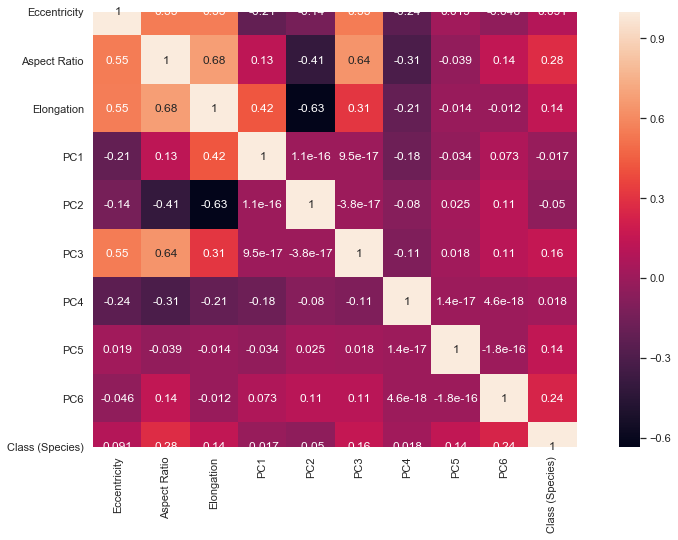

In [ ]:
sns.heatmap(leaf_data_pca[['Eccentricity', 'Aspect Ratio', 'Elongation', 'PC1', 'PC2',
                           'PC3', 'PC4', 'PC5', 'PC6', 'Class (Species)']].corr(), vmax=1, square=True, annot=True)

**Comment:**

* We can clearly see that there is no high correlations between the principal components. Thus, we eliminated the strongly correlated features. It remains only few slight correlated ones with maximum correlation around $0.6$.

# Pre-processing

As a pre-processing step, we need to devide the data into features and target. Next, we devide it into train and test datasets for the modeling procedure.

In [ ]:
classes = leaf_data_pca['Class (Species)']
leaf_data_pca = leaf_data_pca.drop(columns=['Class (Species)'])
leaf_data_pca = leaf_data_pca.drop(columns=['Specimen Number'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(leaf_data_pca, classes, test_size=0.25, random_state=42, shuffle=True, stratify=classes)

All features are numerical, we need now to normalize our data.

In [ ]:
# Define scaler
scaler = StandardScaler()
# Fit scaler on train dataset
scaler = scaler.fit(X_train)
# Transform train and test datasets
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# Modeling

In this part, we'll try to build predictive models in order to classify leaf images into different categories. <br>
As a first step, we'll use **handcrafted** features and apply some **Machine Learning algorithms**. Next, we'll use **deep features** by applying **Deep Learning algorithms**.

## Machine Learning Approach

### SVM classifier

 Average and std TRAIN CV accuracy : 0.8529411764705884 +- 0.011178190442148421
 Average and std TEST CV accuracy : 0.7058823529411764 +- 0.02772967769359011


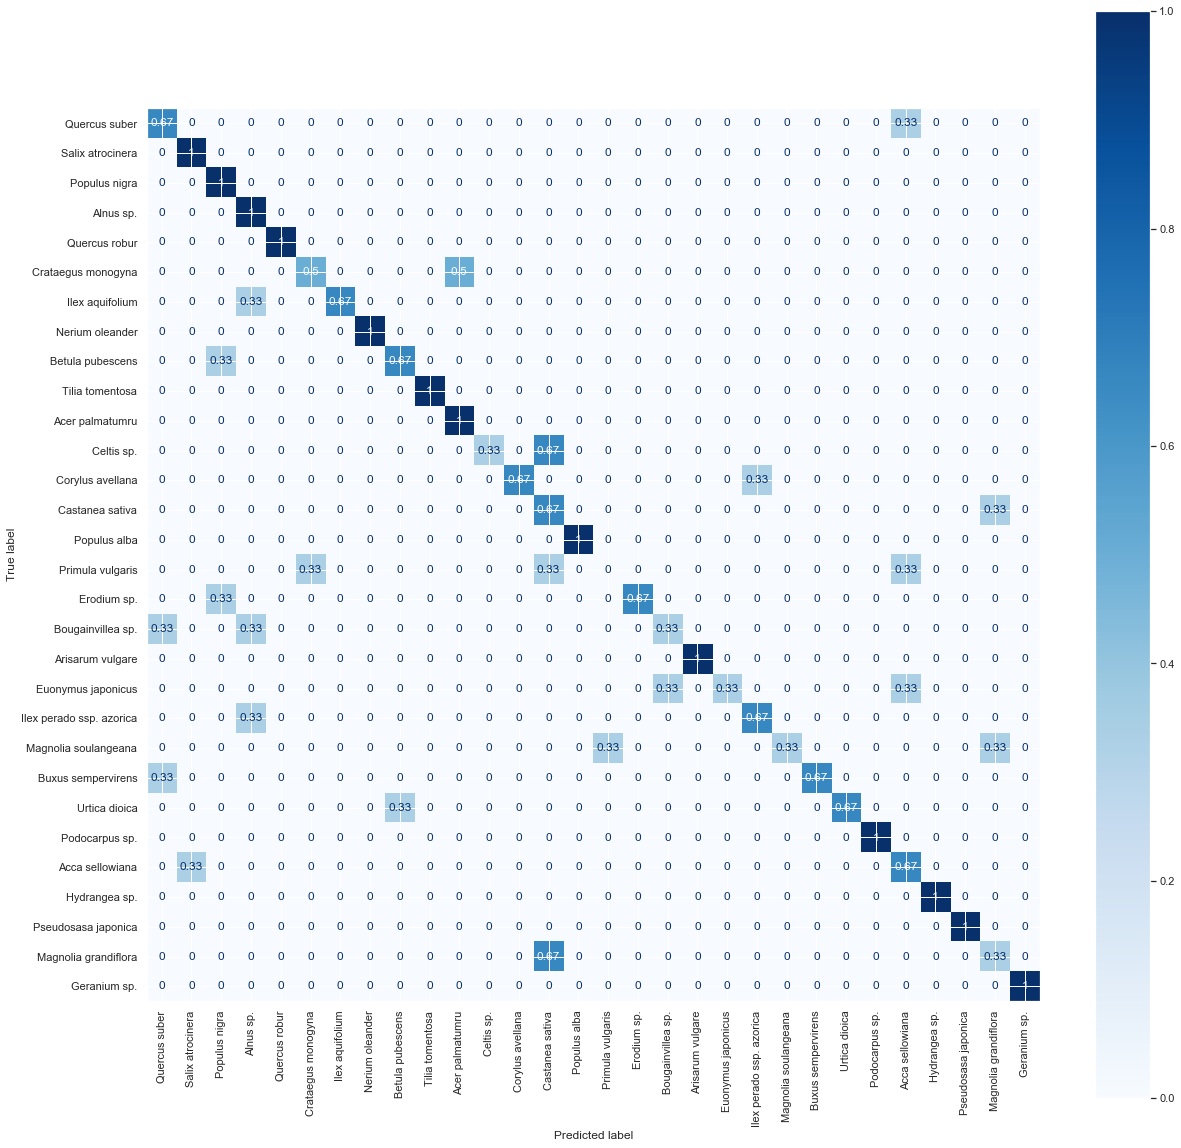

In [ ]:
# Fitting linear SVM
Lsvm = SVC(kernel='linear', C=1, decision_function_shape='ovo', random_state=0)
Lsvm_cv = cross_validate(Lsvm, X_train, y_train, cv=5,
                         return_train_score=True, return_estimator=True)

# Display scores
print(" Average and std TRAIN CV accuracy : {0} +- {1}".format(
    Lsvm_cv['train_score'].mean(), Lsvm_cv['train_score'].std()))
print(" Average and std TEST CV accuracy : {0} +- {1}".format(
    Lsvm_cv['test_score'].mean(), Lsvm_cv['test_score'].std()))

# Look for the best estimator (the one with the greatest test accuracy)
index_best = np.argmax(Lsvm_cv['test_score'])
estimator_best = Lsvm_cv['estimator'][index_best]

# Predict
y_pred = estimator_best.predict(X_test)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(estimator_best, X_test, y_test, normalize='true', cmap=plt.cm.Blues, display_labels=class_names, xticks_rotation='vertical',
                      ax=ax)
plt.show()

**Interpretation:** 

* The linear SVM classifier gives us a relatively good results for training dataset with a score of $0.85$, but lower score for test dataset ($0.7$). Thus, we can say that the model slightly overfits.

* According to the confusion matrix, we can see that the model **perfectly** classify $13$ classes among a total of $30$ classes. The well classified leaf categories are : **'Salix atrocinera', 'Populus nigra', 'Alnussp.', 'Quercus robur', 'Nerium oleandr', 'Tilia tomentosa', 'Acer Palmatumru', 'Populus alba', 'Arisarum vulgare', 'Podocarpus sp.', 'Hydrangea sp.', 'Pseudodasa japonica', and 'Geranium sp.'.

* However, there is a class that the model predicts *completly wrong*, which is **Primula vulgaris**. It is predicted with $0.33\%$ each of the classes **'crataegus monogyna', 'Castanea sativa', and 'Acca sellowiana'**.

* As for the rest of the classes, $10$ of them are classified with a good score of $0.65\%$, whereas the others are badly classified with a score of only $0.33\%$ and $0.5\%$.

### Decision Trees

In [ ]:
# Define Decision Tree classifier
Tree_clf = DecisionTreeClassifier(random_state=0)

# Fit model
Tree_clf.fit(X_train, y_train)

# Predict
y_pred = Tree_clf.predict(X_test)

# Print train and test scores
print("Decision Tree train score :", Tree_clf.score(X_train, y_train))
print("Decision Tree test score :", Tree_clf.score(X_test, y_test))

Decision Tree train score : 1.0
Decision Tree test score : 0.6470588235294118


**Comment:**

* We clearly notice that the model overfits with $100\%$ accuracy for train dataset and only $64\%$ accuracy for test dataset. <br><br>
Thus, we'll apply **Cross validation** technique in order to eliminate the problem of overfitting.

In [ ]:
# Define Decision Tree classifier
Tree = DecisionTreeClassifier(random_state=0)

# Define parameters for cross validation
p_grid_tree = {'min_samples_split': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14], 'min_samples_leaf': [
    2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]}

# Compute cross validation
grid_tree = GridSearchCV(
    estimator=Tree, param_grid=p_grid_tree, scoring="accuracy", cv=5)

# Train the classifier
grid_tree.fit(X_train, y_train)

# Retrieve best parameters
best_params = grid_tree.best_params_
print('Best parameters : ', best_params)

# Compute best model
best_model_tree = DecisionTreeClassifier(
    min_samples_split=best_params['min_samples_split'], min_samples_leaf=best_params['min_samples_leaf'])

# Train best model
best_model_tree.fit(X_train, y_train)

# Predict
y_pred = best_model_tree.predict(X_test)

# Print train and test scores
print("Decision Tree train score :", best_model_tree.score(X_train, y_train))
print("Decision Tree test score :", best_model_tree.score(X_test, y_test))

Best parameters :  {'min_samples_leaf': 2, 'min_samples_split': 7}
Decision Tree train score : 0.8784313725490196
Decision Tree test score : 0.6823529411764706


**Comment:**

* Through the resulting scores, we can see that the Decision tree classifier has improved and the problem of overfitting is reduced as the train score decreased and the test score increased to be closer. However, we cannot say that the overfitting problem is eliminated. 

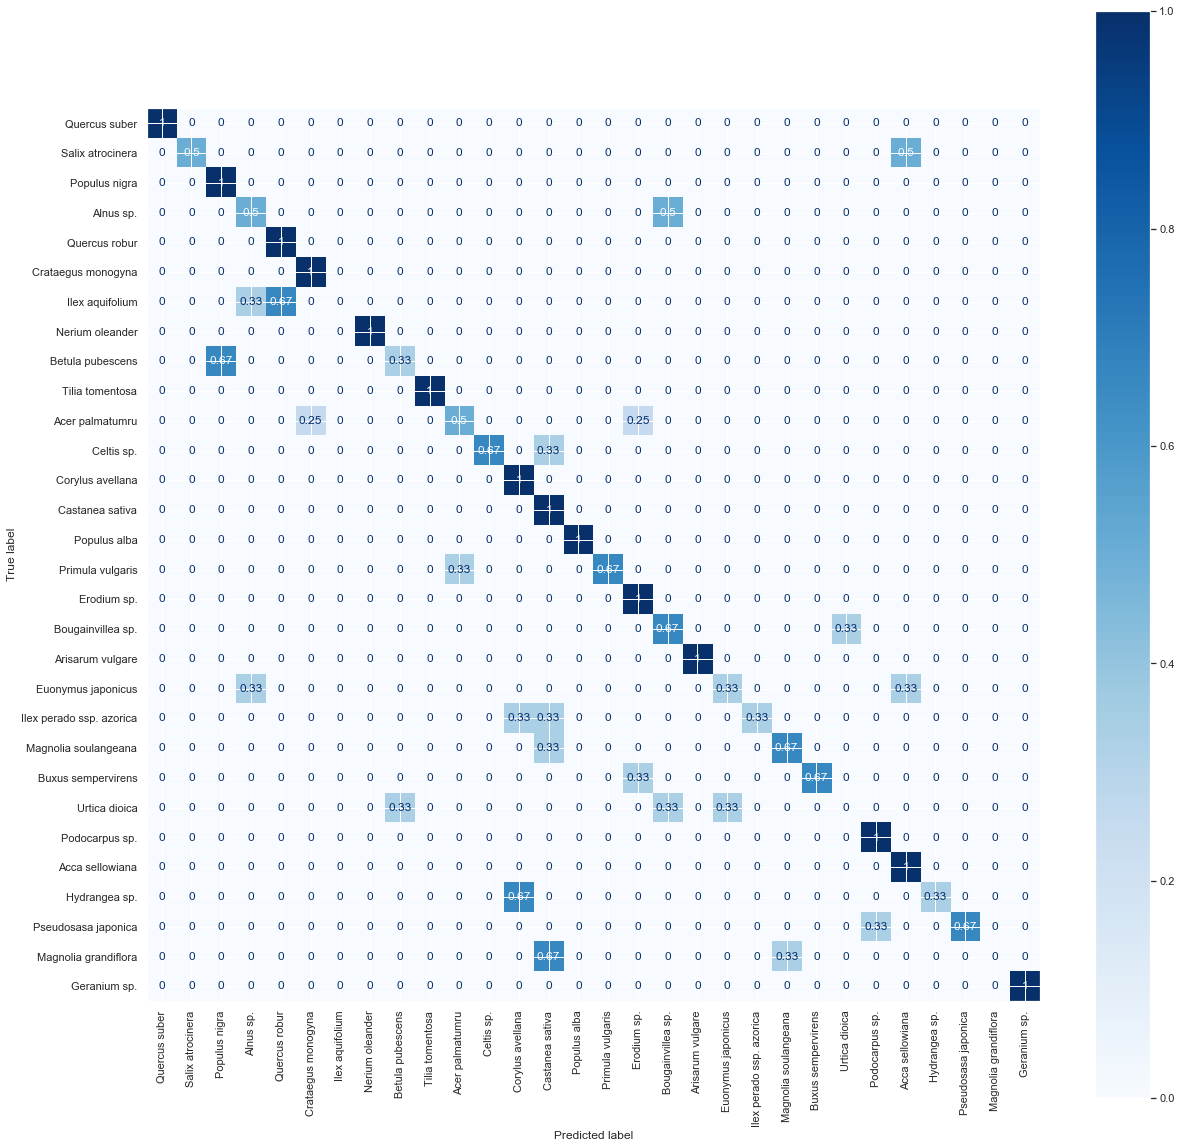

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(best_model_tree, X_test, y_test, normalize='true', cmap=plt.cm.Blues, display_labels=class_names, xticks_rotation='vertical',
                      ax=ax)
plt.show()

**Comment**:

* The Decision Tree classifier works worse than SVM classifier in this case. In fact, even both classifiers' scores are very close, but we can remark through the Confusion Matrix that Decision Tree classifies completely wrong $3$ leaf categories, not only one. Thus, we can say that for our dataset, SVM works better that Decision Tree.

### Random Forest

In [ ]:
# Define classifier
RF = RandomForestClassifier(random_state=0)

# Define parameters for cross validation
p_grid_RF = {'n_estimators': [30, 40, 50, 55, 60, 75, 90], 'min_samples_leaf': [
    2, 3, 4, 5, 6], 'max_features': ['sqrt', 'log2'], 'max_leaf_nodes': [14, 15, 16, 17, 18, 19]}

# Compute cross validation
grid_RF = GridSearchCV(estimator=RF, param_grid=p_grid_RF,
                       scoring="accuracy", cv=5)

# Train the classifier
grid_RF.fit(X_train, y_train)

# Retrieve best parameters
best_params = grid_RF.best_params_
print("Best params: {}".format(best_params))

# Compute best model
best_model_RF = RandomForestClassifier(n_estimators=best_params['n_estimators'], min_samples_leaf=best_params['min_samples_leaf'],
                                       max_features=best_params['max_features'], max_leaf_nodes=best_params['max_leaf_nodes'], random_state=0)

# Train best model
best_model_RF.fit(X_train, y_train)

# Print train and test scores
print("Random Forest train score :", best_model_RF.score(X_train, y_train))
print("Random Forest test score :", best_model_RF.score(X_test, y_test))

Best params: {'max_features': 'sqrt', 'max_leaf_nodes': 17, 'min_samples_leaf': 4, 'n_estimators': 55}
Random Forest train score : 0.8627450980392157
Random Forest test score : 0.7411764705882353


**Comment:**

* We can clearly notice that the Random Forest model has reduced more the overfitting ; the gap between train and test scores decreased. 

* In order to eliminate further this problem, we can minimize the maximum depth the tree can achieve from the start by introducing the `max_depth` argument. 

In [ ]:
# Define classifier
# We choose max_depth = 8
best_model_RF = RandomForestClassifier(n_estimators=best_params['n_estimators'], min_samples_leaf=best_params['min_samples_leaf'],
                                       max_features=best_params['max_features'], max_leaf_nodes=best_params['max_leaf_nodes'],
                                       max_depth=6, random_state=0)

# Train the classifier
best_model_RF.fit(X_train, y_train)

# Print train and test scores
print("Random Forest train score :", best_model_RF.score(X_train, y_train))
print("Random Forest test score :", best_model_RF.score(X_test, y_test))

Random Forest train score : 0.8588235294117647
Random Forest test score : 0.7529411764705882


**Comment:**

* We can remark that by minimizing the maximum depth the tree can achieve  by setting `max_depth = 6`, the model is less overfitting.

### Feature importance using Random Forest

**Random forest** can be used to evaluate the importance of features on a classification task. Thus, we'll try to determine which features are most relevant for the task of leaves classification.

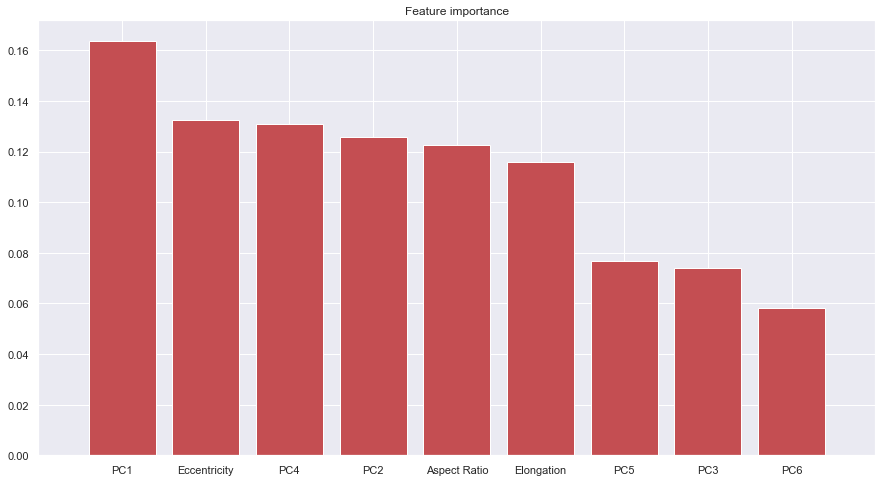

In [ ]:
# Compute features importances
importances = best_model_RF.feature_importances_

# Retrieve features indices
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(9), importances[indices[0:9]], color="r", align="center")
plt.xticks(range(9), leaf_data_pca.columns[indices[0:9]])
plt.xlim([-1, 9])
plt.show()

**Comment:**

* We can observe that **PC1** is the most important feature for the classification task with more than $16\%$ of contribution.
* **'Eccentricity', 'Elongation', 'PC2', 'PC4', and 'Aspect Ratio'** are the next most important features with importance going from $11\%$ to $12.5\%$.
* The least important features are **'PC5', 'PC3', and 'PC6'** with importance from $6\%$ to $7\%$.

* This technique can be useful to select the most important features and get rid of the least important one. This may help the models improve and learn better.

### Boosting

In [ ]:
# NB. This cell takes a very long time to execute

# Define parameters
param_grid = {'n_estimators': [100, 300, 500],
              'learning_rate': [0.1, 0.05, 0.02],
              'max_depth': [4, 5],
              'min_samples_leaf': [3, 5],
              'max_features': [1.0]}

# Define classifier
estimator = GradientBoostingClassifier()

# Apply cross validation
classifier = GridSearchCV(estimator=estimator, cv=5, param_grid=param_grid)

# train the classifier
classifier.fit(X_train, y_train)

# Retrieve best parameters
best_param = classifier.best_estimator_

# Define best classifier
best_model = GradientBoostingClassifier(learning_rate=best_param.learning_rate, max_depth=best_param.max_depth,
                                        max_features=best_param.max_features,
                                        min_samples_leaf=best_param.min_samples_leaf,
                                        n_estimators=best_param.n_estimators)

# Train best classifier
best_model.fit(X_train, y_train)

# Evaluate the model
print(best_model.score(X_train, y_train))
print(best_model.score(X_test, y_test))

1.0
0.6352941176470588


**Comment:**

* As we see, the boosting classifier clearly overfits as it gives $100\%$ of accuracy for the training dataset and %63\% for the test dataset even with cross validation on multiple values of its parameters. This can be due to the fact that the weak classifiers, which are decision trees, are overfitting as well, as seen previously, which led to worse results with boosting. 

# Conclusion - Machine Learning algorithms

As seen above, the different machine learning classifiers gave approximate results except the gradient boosting which strongly overfitted. However, the best accuracy was given by the Random Forest classifier with around $85\%$ on training dataset and $75\%$ on test dataset.
<br> <br> We'll see in the next section if using deep features computed from deep learning algorithms will improve the results given by machine learning algorithms on handcrafted features.

## Deep Learning Approach

In this section, we'll try to apply deep learning algorithms to classify the leaf images into $40$ different categories.
<br><br>
We'll mount drive to import data (RGB folder).

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


We load now the images with their labels.

In [3]:
# Load data

# Useful function
def filelist(root, file_type):
    """This function returns a fully-qualified list of filenames under root directory"""
    return [os.path.join(directory_path, f) for directory_path, directory_name,
            files in os.walk(root) for f in files if f.endswith(file_type)]


# Path for images directory
# if local -> path_images = '.\\RGB'
path_images = '/content/drive/MyDrive/TELECOMPARIS/SD210/Project/RGB'

# retrieve filenames
filenames_images = filelist(path_images, 'JPG')

# Load images
images = []
labels = []

shape = (800, 800, 3)

for filename in filenames_images:
    images.append(resize(imread(filename), shape).astype('float32'))
    # if local -> labels.append(int(filename.split('\\')[2].split('.')[0]))
    labels.append(int(filename.split('/')[-2].split('.')[0]))
images = np.array(images)
labels = np.array(labels)
print('The data contains {0} images of {1} different categories.'.format(
    images.shape[0], len(set(labels))))

The data contains 443 images of 40 different categories.


The classes goes from 1 to 40. Or, Deep Learning algorithms suppose labels starting from 0. Thus, we consider our classes : 0 -> 39

In [4]:
labels = [labels[i]-1 for i in range(labels.shape[0])]

### One-hiden-layer Architecture

We build now the first model : One-hiden-layer Architecture.

In [9]:
# Create the model

model = Sequential()
model.add(Input(images[0].shape))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(40, activation='softmax'))

# Summary of the model
model.summary()

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1920000)           0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                122880064 
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 40)                2600      
Total params: 122,882,920
Trainable params: 122,882,792
Non-trainable params: 128
_________________________________________________________________


In order to overcome overfitting, we stop the training when a monitored metric `val_loss` stops improving using the module **EarlyStopping** from `Callbacks`, and restore the best model by setting `restore_best_weights = True`.

In [5]:
early_stop = EarlyStopping(monitor='val_loss', mode='auto',
                           restore_best_weights=True, patience=8)
calls = [early_stop]

We train now the model. To do so, we need to split data into train and validation datasets.

In [11]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.1, random_state=0)

# Transform the target variable to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Fit model
n_epochs = 50
batch_size = 32
history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=[calls])

Epoch 1/50
13/13 [==============================] - 2s 122ms/step - loss: 3.6818 - accuracy: 0.0451 - val_loss: 117.4225 - val_accuracy: 0.0444
Epoch 2/50
13/13 [==============================] - 1s 106ms/step - loss: 3.4697 - accuracy: 0.0859 - val_loss: 64.9167 - val_accuracy: 0.0444
Epoch 3/50
13/13 [==============================] - 1s 108ms/step - loss: 3.3776 - accuracy: 0.0946 - val_loss: 43.1709 - val_accuracy: 0.0444
Epoch 4/50
13/13 [==============================] - 1s 107ms/step - loss: 3.2033 - accuracy: 0.1653 - val_loss: 32.0637 - val_accuracy: 0.0444
Epoch 5/50
13/13 [==============================] - 1s 110ms/step - loss: 3.1079 - accuracy: 0.1994 - val_loss: 24.6490 - val_accuracy: 0.0444
Epoch 6/50
13/13 [==============================] - 1s 105ms/step - loss: 3.0709 - accuracy: 0.1929 - val_loss: 19.3299 - val_accuracy: 0.0444
Epoch 7/50
13/13 [==============================] - 1s 106ms/step - loss: 2.9811 - accuracy: 0.2026 - val_loss: 15.6857 - val_accuracy: 0.044

We plot the evolution of accuracy and validation loss across epochs.

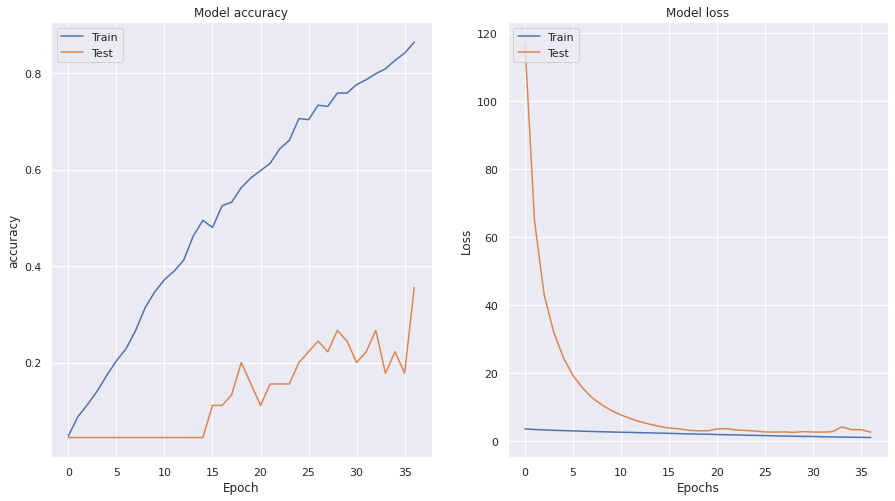

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Comment:**

* We can see that the model doesn't learn well on test dataset as on train dataset. However, the loss decreases progressively until reaching the training loss.

We now evaluate the model using the `balanced_accuracy_score` metric.

In [32]:
y_pred_train = model.predict_classes(X_train)
y_pred_test = model.predict_classes(X_test)

y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

print('Train accuracy :', balanced_accuracy_score(y_train, y_pred_train))
print('Test accuracy :', balanced_accuracy_score(y_test, y_pred_test))

Train accuracy : 0.31900252525252526
Test accuracy : 0.2948717948717949


### MLP Architecture

As we see the last model doesn't provide good results. To improve it we can add more layers.

In [31]:
# Create the model
model = Sequential()
model.add(Input(images[0].shape))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(40, activation='softmax'))

# Summary of the model
model.summary()

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy',
              metrics=['accuracy'])

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 1920000)           0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               245760128 
_________________________________________________________________
batch_normalization_13 (Batc (None, 128)               512       
_________________________________________________________________
dense_19 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_14 (Batc (None, 64)                256       
_________________________________________________________________
dense_20 (Dense)             (None, 32)                2080      
_________________________________________________________________
batch_normalization_15 (Batc (None, 32)               

We train now the model.

In [32]:
early_stop = EarlyStopping(monitor='val_loss', mode='auto',
                           restore_best_weights=True, patience=5)
calls = [early_stop]

In [33]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, test_size=0.1, random_state=0)

# Transform the target variable to binary class matrix
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Fit model
n_epochs = 40
batch_size = 32
history = model.fit(X_train, y_train,
                    epochs=n_epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, y_test),
                    callbacks=[calls])

Epoch 1/40
13/13 [==============================] - 2s 123ms/step - loss: 3.7929 - accuracy: 0.0541 - val_loss: 112.6971 - val_accuracy: 0.0000e+00
Epoch 2/40
13/13 [==============================] - 1s 114ms/step - loss: 3.3418 - accuracy: 0.1145 - val_loss: 66.7262 - val_accuracy: 0.0000e+00
Epoch 3/40
13/13 [==============================] - 1s 114ms/step - loss: 3.0311 - accuracy: 0.2227 - val_loss: 45.4117 - val_accuracy: 0.0000e+00
Epoch 4/40
13/13 [==============================] - 1s 114ms/step - loss: 2.8234 - accuracy: 0.2645 - val_loss: 32.0835 - val_accuracy: 0.0000e+00
Epoch 5/40
13/13 [==============================] - 1s 110ms/step - loss: 2.5597 - accuracy: 0.3690 - val_loss: 24.4367 - val_accuracy: 0.0444
Epoch 6/40
13/13 [==============================] - 1s 115ms/step - loss: 2.4006 - accuracy: 0.4414 - val_loss: 19.3057 - val_accuracy: 0.0444
Epoch 7/40
13/13 [==============================] - 1s 114ms/step - loss: 2.2735 - accuracy: 0.4603 - val_loss: 15.6820 - val

We plot the evolution of accuracy and validation loss across epochs.

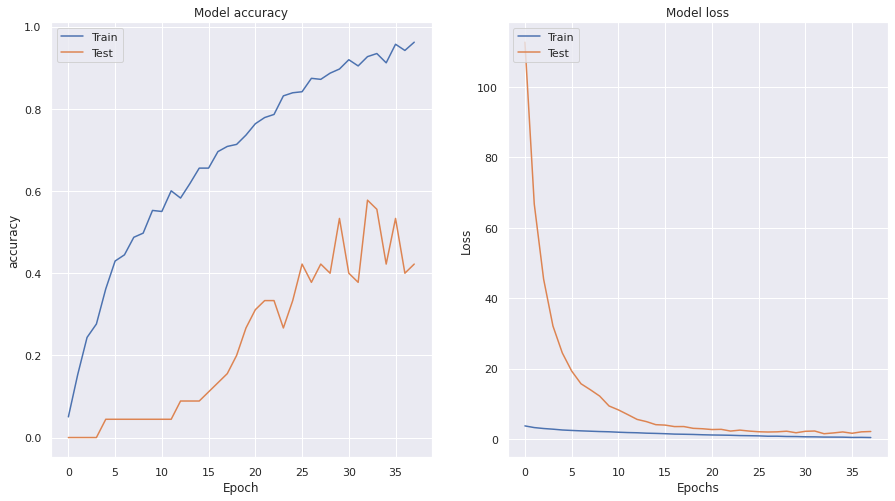

In [34]:
# Plot training & validation accuracy values
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

We evaluate the model.

In [35]:
y_pred_train = model.predict_classes(X_train)
y_pred_test = model.predict_classes(X_test)

y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

print('Train accuracy:', balanced_accuracy_score(y_train, y_pred_train))
print('Test accuracy:', balanced_accuracy_score(y_test, y_pred_test))

Train accuracy: 0.7686760461760461
Test accuracy: 0.6153846153846154


**Comment:**

* As we see, after adding more layers, the model improved a lot from $31\%$ to $76\%$ for train dataset and from $29\%$ to $61\%$ for test dataset. And we can notice also that using `EarlyStopping` the model does not overfit. <br>
We can say thus, the model is relatively efficient.

# General Conclusion

$~~~~$ In this project, we built several machine learning models in first section that predict 30 different leaf categories based on shape and texture features. We succeeded in reaching an accuracy of $85\%$ for training dataset and $75\%$ for test dataset given by the Random Forest classifier. In the second section, we built different MLP architectures and trained them on leaf images. The best deep learning model gave us an accuracy of $76\%$ for the training dataset and $61\%$ for the test dataset. <br>
$~~~~$ In this specific problem, the machine learning approach outperformed the deep learning approach with a difference of $9\%$ in accuracy thanks to the Random Forest classifier. <br>
$~~~~$ This was largely due to the limited data size and precisely to the limited number of samples for too many classes, and we know that Deep learning models are suited for large datasets unlike machine learnings models that work better with small datasets, which is the case in this project.